In [1]:
import shutil
from csv import reader
import numpy as np
import glob
from datetime import datetime
from pyspark.sql import *
from pyspark.sql.functions import col
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pandas as pd
from geopandas.tools import sjoin

In [2]:
requests = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
                                            inferschema='true').load('311_Service_Requests_from_2010_to_Present.csv')
first = requests.take(1)

In [3]:
requests.registerTempTable("a311")
print first, requests.count()

[Row(Unique Key=32840317, Created Date=u'03/05/2016 02:25:42 AM', Closed Date=u'03/05/2016 05:32:11 PM', Agency=u'NYPD', Agency Name=u'New York City Police Department', Complaint Type=u'Noise - Residential', Descriptor=u'Loud Talking', Location Type=u'Residential Building/House', Incident Zip=u'11215', Incident Address=u'594 5 AVENUE', Street Name=u'5 AVENUE', Cross Street 1=u'16 STREET', Cross Street 2=u'PROSPECT AVENUE', Intersection Street 1=u'', Intersection Street 2=u'', Address Type=u'ADDRESS', City=u'BROOKLYN', Landmark=u'', Facility Type=u'Precinct', Status=u'Closed', Due Date=u'03/05/2016 10:25:42 AM', Resolution Description=u'The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.', Resolution Action Updated Date=u'03/05/2016 05:32:11 PM', Community Board=u'07 BROOKLYN', Borough=u'BROOKLYN', X Coordinate (State Plane)=u'986922', Y Coordinate (State Plane)=u'181325', Park Facility Name=u'Unspecifie

In [4]:
cleaned = requests.where((col("Complaint Type") == "Drinking") |
                               (col("Complaint Type") == "Drug Activity") |
                               (col("Complaint Type") == "Street Light Condition"))

# cleaned = requests.where((col("Complaint Type") == "Drinking") |
#                                (col("Complaint Type") == "Safety") |
#                                (col("Complaint Type") == "Drug Activity") |
#                                (col("Complaint Type") == "Noise - Park") |
#                                (col("Complaint Type") == "Street Light Condition"))

In [5]:
cleaned.count()

714530

In [6]:
ind = [1, 5, 6, -3, -2]
selected = map(lambda x: requests.columns[x], ind)
cleaned_f = cleaned.select(selected)

In [7]:
first= cleaned_f.take(1)
first

[Row(Created Date=u'03/05/2016 06:13:00 PM', Complaint Type=u'Street Light Condition', Descriptor=u'Street Light Out', Latitude=40.71379279827319, Longitude=-73.79187167662333)]

In [8]:
cleaned_f.write.csv('output0')

In [9]:
# Merging
with open('step0.csv', 'wb') as outpt:
    for name in glob.glob('output0/p*'):
        with open(name, 'rb') as inpt:
            shutil.copyfileobj(inpt, outpt)

In [10]:
with open('step0.csv', 'rb') as inpt:
    step0 = map(lambda row: row, reader(inpt))

In [11]:
print step0[0], "\n", len(step0)

['08/10/2016 01:21:00 PM', 'Street Light Condition', 'Street Light Out', '', ''] 
714530


In [12]:
starttime = datetime.strptime('07/01/2014 12:00:00 AM', '%m/%d/%Y %I:%M:%S %p')
endtime = datetime.strptime('10/01/2016 12:00:00 AM', '%m/%d/%Y %I:%M:%S %p')
print starttime, endtime

2014-07-01 00:00:00 2016-10-01 00:00:00


In [13]:
step0 = map(lambda row: [datetime.strptime(row[0], '%m/%d/%Y %I:%M:%S %p')]+row[1:], step0)

In [14]:
print step0[0], "\n", len(step0)

[datetime.datetime(2016, 8, 10, 13, 21), 'Street Light Condition', 'Street Light Out', '', ''] 
714530


In [15]:
filtered = sorted(filter(lambda row: row[0]<=endtime and row[0]>=starttime, step0), key = lambda x: x[0])

In [16]:
print filtered[0], "\n", filtered[-1], "\n", len(filtered)

[datetime.datetime(2014, 7, 1, 0, 52), 'Street Light Condition', 'Lamppost Base Door/Cover Missing', '', ''] 
[datetime.datetime(2016, 9, 30, 23, 50), 'Street Light Condition', 'Lamppost Base Door/Cover Damaged', '40.69044677627941', '-73.83290446301469'] 
218239


In [17]:
filtered = filter(lambda x: x[-1]<>'' and x[-2]<>'', filtered)

In [18]:
len(filtered)

131779

In [19]:
prks = gpd.GeoDataFrame.from_file('park.shp')

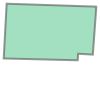

In [20]:
prks.iloc[0].geometry

In [21]:
prks = prks[['geometry', 'park_name', 'shape_area']]

In [22]:
prks.head(2)

,geometry,park_name,shape_area
0,POLYGON ((-73.97922375065221 40.69799879369959...,Commodore Barry Park,41539.801363
1,POLYGON ((-73.99732028095745 40.69600764072165...,Pierrepont Playground,21960.494920


In [23]:
a311df = pd.DataFrame.from_records(filtered, columns=['Created_Time', 'Complaint', 'Details', 'Lat', 'Long'])

In [24]:
a311df.head(3)

,Created_Time,Complaint,Details,Lat,Long
0,2014-07-01 01:08:00,Street Light Condition,Lamppost Missing,40.717200165228554,-73.99070377473507
1,2014-07-01 01:11:00,Street Light Condition,Street Light Out,40.62466637345132,-73.96600432599404
2,2014-07-01 01:21:00,Street Light Condition,Street Light Out,40.760204814768336,-73.93747256682728


In [25]:
a311df['Lat'] = a311df['Lat'].apply(lambda x: float(x))
a311df['Long'] = a311df['Long'].apply(lambda x: float(x))

In [26]:
geometry = [Point(xy) for xy in zip(a311df['Long'], a311df['Lat'])]

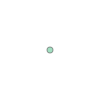

In [27]:
geometry[0]

In [28]:
a311df = a311df[['Created_Time', 'Complaint', 'Details']]

In [29]:
geo311 = GeoDataFrame(a311df, crs = {'init': 'epsg:4326'}, geometry = geometry)
geo311['geometry'] = geo311['geometry'].apply(lambda x: gpd.GeoSeries(x).buffer(0.001))

In [30]:
geo311.head(3)

,Created_Time,Complaint,Details,geometry
0,2014-07-01 01:08:00,Street Light Condition,Lamppost Missing,POLYGON ((-73.98970377473506 40.71720016522855...
1,2014-07-01 01:11:00,Street Light Condition,Street Light Out,POLYGON ((-73.96500432599403 40.62466637345132...
2,2014-07-01 01:21:00,Street Light Condition,Street Light Out,POLYGON ((-73.93647256682728 40.76020481476834...


In [31]:
prks.head(10)

,geometry,park_name,shape_area
0,POLYGON ((-73.97922375065221 40.69799879369959...,Commodore Barry Park,4.153980e+04
1,POLYGON ((-73.99732028095745 40.69600764072165...,Pierrepont Playground,2.196049e+04
2,POLYGON ((-73.99557419919979 40.68792918280799...,Cobble Hill Park,2.807908e+04
3,POLYGON ((-73.97746661925957 40.69650941986475...,Commodore Barry Park,4.384161e+05
4,POLYGON ((-73.99746719287955 40.69692380834881...,Brooklyn Heights Promenade,1.446570e+04
5,POLYGON ((-73.99830711319798 40.69531715452282...,Brooklyn Heights Promenade,4.635878e+04
6,POLYGON ((-73.99451494985468 40.70394341746722...,Brooklyn Bridge Park,1.995609e+06
7,POLYGON ((-73.98008667776499 40.69796760030253...,Commodore Barry Park,1.367777e+03
8,POLYGON ((-73.98018572731112 40.69809644559253...,Commodore Barry Park,1.489199e+03
9,POLYGON ((-73.98233515032896 40.69808061965792...,Golconda Playground,1.473095e+03


In [32]:
geo311.to_csv('ComplaintsGeo.csv')

In [33]:
with open('parks.csv', 'rb') as inpt:
    park_list = map(lambda row: row, reader(inpt))

In [34]:
parks_merged = prks.dissolve(by='park_name')

In [35]:
parks_merged = parks_merged.reset_index()
parks_merged.head(10)

,park_name,geometry,shape_area
0,"""Uncle"" Vito E. Maranzano Glendale Playground",POLYGON ((-73.88152476475133 40.70529950390424...,6687.637331
1,100% Playground,"POLYGON ((-73.8997241390196 40.6465536310036, ...",3933.762638
2,101st St. Soccer Field,POLYGON ((-73.97360601490826 40.80064096880579...,1772.610175
3,104th St. Softball Field,POLYGON ((-73.97334878405498 40.80163070935411...,56118.417075
4,110th Street Block Association Garden,POLYGON ((-73.94718122076823 40.79614575205431...,2208.126140
5,117th St Community Garden,POLYGON ((-73.94043480761923 40.79893155754588...,3389.587219
6,132 St Block Association Park,"POLYGON ((-73.94295390158399 40.812369770225, ...",8371.799943
7,14 Honey Locusts Park,(POLYGON ((-73.96257159898309 40.7599785113595...,12271.213891
8,157 St Playground,(POLYGON ((-73.78679848010727 40.6844998577174...,121877.602841
9,16 Linden Trees Triangle,POLYGON ((-73.95257901000322 40.58420663471234...,18548.601206


In [36]:
print len(prks), " ", len(parks_merged)

12491   2030


In [37]:
park_list = map(lambda x: x[0].lower(), park_list)

In [38]:
parks_merged['park_name'] = parks_merged['park_name'].apply(lambda x: x.lower())

In [39]:
parks_merged.head(3)

,park_name,geometry,shape_area
0,"""uncle"" vito e. maranzano glendale playground",POLYGON ((-73.88152476475133 40.70529950390424...,6687.637331
1,100% playground,"POLYGON ((-73.8997241390196 40.6465536310036, ...",3933.762638
2,101st st. soccer field,POLYGON ((-73.97360601490826 40.80064096880579...,1772.610175


In [40]:
parks_merged = parks_merged[parks_merged['park_name'].isin(park_list)]
print parks_merged.head(3), len(parks_merged)

                                        park_name  \
0   "uncle" vito e. maranzano glendale playground   
1                                 100% playground   
28                         abe stark skating rink   

                                             geometry     shape_area  
0   POLYGON ((-73.88152476475133 40.70529950390424...    6687.637331  
1   POLYGON ((-73.8997241390196 40.6465536310036, ...    3933.762638  
28  POLYGON ((-73.98538945921833 40.57474167812293...  382563.169367   749


In [41]:
parks_merged = parks_merged[['park_name', 'geometry']]
parks_merged.crs = {'init': 'epsg:4326'}

In [42]:
geo311.head(3)

,Created_Time,Complaint,Details,geometry
0,2014-07-01 01:08:00,Street Light Condition,Lamppost Missing,POLYGON ((-73.98970377473506 40.71720016522855...
1,2014-07-01 01:11:00,Street Light Condition,Street Light Out,POLYGON ((-73.96500432599403 40.62466637345132...
2,2014-07-01 01:21:00,Street Light Condition,Street Light Out,POLYGON ((-73.93647256682728 40.76020481476834...


In [43]:
print parks_merged.crs, " ", geo311.crs

{'init': 'epsg:4326'}   {'init': 'epsg:4326'}


In [44]:
joined = sjoin(geo311, parks_merged, how = 'inner', op = 'intersects')

/home/denis/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2652: RuntimeWarning: invalid value encountered in find_intersects (vectorized)
  outputs = ufunc(*inputs)


In [45]:
len(joined)

28526

In [46]:
#world = world.to_crs({'init': 'epsg:3395'})
#world.plot();
joined.tail(100)

,Created_Time,Complaint,Details,geometry,index_right,park_name
60763,2015-07-14 16:42:00,Street Light Condition,Street Light Out,POLYGON ((-73.84906039529461 40.86573573157896...,54,allerton playground
88654,2015-12-30 13:32:00,Street Light Condition,Street Light Lamp Dim,"POLYGON ((-73.8500157432694 40.86534722156919,...",54,allerton playground
95332,2016-02-11 16:36:00,Street Light Condition,Street Light Out,"POLYGON ((-73.8500157432694 40.86534722156919,...",54,allerton playground
106007,2016-04-18 15:39:00,Street Light Condition,Street Light Out,"POLYGON ((-73.8500157432694 40.86534722156919,...",54,allerton playground
106806,2016-04-22 09:40:00,Street Light Condition,Street Light Out,POLYGON ((-73.84906039529461 40.86573573157896...,54,allerton playground
110827,2016-05-17 13:55:00,Street Light Condition,Street Light Out,"POLYGON ((-73.8500157432694 40.86534722156919,...",54,allerton playground
119953,2016-07-15 12:45:00,Street Light Condition,Street Light Out,"POLYGON ((-73.8500157432694 40.86534722156919,...",54,allerton playground
122417,2016-08-01 20:16:00,Street Light Condition,Street Light Out,"POLYGON ((-73.8500157432694 40.86534722156919,...",54,allerton playground
124208,2016-08-12 21:34:00,Street Light Condition,Street Light Out,POLYGON ((-73.85001484550185 40.86574794669372...,54,allerton playground
62263,2015-07-22 20:38:00,Street Light Condition,Street Light Out,POLYGON ((-73.98986736073319 40.73437686747114...,1888,union square park


In [47]:
def quartals(date):
    date = str(date).split('-')
    year = date[0]
    month = date[1]
    quartal = '1'
    if month in ['04', '05', '06']:
        quartal = '2'
    if month in ['07', '08', '09']:
        quartal = '3'
    if month in ['10', '11', '12']:
        quartal = '4'
    return year+"-q"+(quartal)

In [48]:
joined['Created_Time'] = joined['Created_Time'].apply(lambda x: quartals(x))

In [56]:
joined.head(5)

,Created_Time,Complaint,Details,geometry,index_right,park_name
0,2014-q3,Street Light Condition,Lamppost Missing,POLYGON ((-73.98970377473506 40.71720016522855...,53,allen mall one
2194,2014-q3,Street Light Condition,Multiple Street Lights Out,"POLYGON ((-73.989364391092 40.71920381197606, ...",53,allen mall one
7300,2014-q3,Street Light Condition,Street Light Out,POLYGON ((-73.98811241142016 40.72030709359785...,53,allen mall one
7853,2014-q3,Street Light Condition,Street Light Out,POLYGON ((-73.98970377473506 40.71720016522855...,53,allen mall one
7913,2014-q3,Street Light Condition,Street Light Out,POLYGON ((-73.98813023116696 40.72164379280751...,53,allen mall one


In [59]:
del joined['Details']

In [68]:
del joined['geometry']
del joined['index_right']

In [69]:
joined.head(5)

,Created_Time,Complaint,park_name
0,2014-q3,Street Light Condition,allen mall one
2194,2014-q3,Street Light Condition,allen mall one
7300,2014-q3,Street Light Condition,allen mall one
7853,2014-q3,Street Light Condition,allen mall one
7913,2014-q3,Street Light Condition,allen mall one


In [95]:
# Combining the complaints into a list
grouped = joined.groupby(['Created_Time', 'park_name']).aggregate(lambda x: tuple(x))
grouped = grouped.reset_index()

In [96]:
grouped.head(3)

,Created_Time,park_name,Complaint
0,2014-q3,"""uncle"" vito e. maranzano glendale playground","(Street Light Condition,)"
1,2014-q3,adam clayton powell jr. malls,"(Street Light Condition, Street Light Conditio..."
2,2014-q3,admiral farragut playground,"(Street Light Condition, Street Light Condition)"


In [97]:
# Preparing columns for counting
grouped['Street_light'] = [0]*len(grouped)
grouped['Drinking'] = [0]*len(grouped)
grouped['Drugs'] = [0]*len(grouped)
grouped['Total'] = [0]*len(grouped)

In [98]:
grouped.head(3)

,Created_Time,park_name,Complaint,Street_light,Drinking,Drugs,Total
0,2014-q3,"""uncle"" vito e. maranzano glendale playground","(Street Light Condition,)",0,0,0,0
1,2014-q3,adam clayton powell jr. malls,"(Street Light Condition, Street Light Conditio...",0,0,0,0
2,2014-q3,admiral farragut playground,"(Street Light Condition, Street Light Condition)",0,0,0,0


In [99]:
# Counting complaints by type
grouped['Street_light'] = grouped['Complaint'].apply(lambda x: len(filter(lambda y: y == 'Street Light Condition', x)))
grouped['Drinking'] = grouped['Complaint'].apply(lambda x: len(filter(lambda y: y == 'Drinking', x)))
grouped['Drugs'] = grouped['Complaint'].apply(lambda x: len(filter(lambda y: y == 'Drug Activity', x)))
grouped['Total'] = grouped['Complaint'].apply(lambda x: len(x))

In [102]:
grouped = grouped[['Created_Time', 'park_name', 'Street_light', 'Drinking', 'Drugs', 'Total']]

In [103]:
grouped.head(5)

,Created_Time,park_name,Street_light,Drinking,Drugs,Total
0,2014-q3,"""uncle"" vito e. maranzano glendale playground",1,0,0,1
1,2014-q3,adam clayton powell jr. malls,4,1,0,5
2,2014-q3,admiral farragut playground,2,0,0,2
3,2014-q3,albert j. parham playground,3,0,0,3
4,2014-q3,allen mall one,7,1,0,8


In [104]:
grouped.to_csv('ComplaintsPerQuartals.csv')

In [53]:
# Obtaining unique complaint types
#complaints = requests.map(get_complain_type).distinct().saveAsTextFile('complaints')